## 1.1 Install Dependecies and Setup

1. labelme
2. tensorflow
3. tensorflow-gpu
4. opencv-python
5. matplotlib
6. albumentations

## 1.2 Collect Images Using OpenCV

In [1]:
import os              # to work with file paths
import time              
import uuid            # to get unique id
import cv2

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

## 1.3 Annotate Images with LabelMe

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')    # this is unique image name ending with jpg 
    cv2.imwrite(imgname, frame)                                 # use to store images in any storage device   
    cv2.imshow('frame', frame)                                  # to show the images on the window
    time.sleep(0.5)                                             # how much time internal you want to capture the image
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Review Dataset and Build Image Loading Funcation

## 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)        # allocate the subset of gpu memory, it will take more memory if needed 

In [4]:
tf.test.is_gpu_available()            

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1


2022-09-14 23:00:21.725046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-14 23:00:21.726076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

In [5]:
tf.config.list_physical_devices('GPU')        # right way to check available gpu's

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.3 Load Image into TF Data Pipeline

In [6]:
images = tf.data.Dataset.list_files('data/images/*.jpg')  #  shuffle=False by deafault it is true

2022-09-14 23:03:18.322131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-14 23:03:18.322173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
images.as_numpy_iterator().next()         #Use as_numpy_iterator to inspect the content of your dataset. To see element shapes and types

b'data/images/d0f7ec46-261c-11ed-acac-1abd0247c66a.jpg'

In [8]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)   # this will return the transformed data in same order as it appeared in the input

In [10]:
images.as_numpy_iterator().next()

2022-09-14 23:05:15.236449: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[186, 186, 178],
        [188, 188, 180],
        [189, 189, 179],
        ...,
        [207, 207, 197],
        [208, 208, 198],
        [210, 210, 200]],

       [[189, 189, 181],
        [189, 189, 181],
        [188, 188, 178],
        ...,
        [207, 207, 197],
        [207, 207, 197],
        [207, 207, 197]],

       [[187, 187, 179],
        [187, 187, 179],
        [187, 187, 179],
        ...,
        [210, 210, 200],
        [208, 208, 196],
        [206, 206, 194]],

       ...,

       [[165, 169, 155],
        [167, 171, 157],
        [168, 172, 158],
        ...,
        [185, 186, 178],
        [184, 185, 177],
        [184, 185, 177]],

       [[165, 169, 155],
        [167, 171, 157],
        [167, 171, 157],
        ...,
        [185, 186, 178],
        [184, 185, 179],
        [184, 185, 179]],

       [[165, 169, 155],
        [166, 170, 156],
        [165, 169, 155],
        ...,
        [185, 186, 178],
        [185, 186, 180],
        [185, 186, 180]]

In [11]:
type(images)         # successfully got images in tf data pipeline

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 View Raw Images With Matplotlib

In [12]:
image_generator = images.batch(4).as_numpy_iterator()  # iterating through data in the batch of 4

In [23]:
plot_images = image_generator.next()     # giving next 4 images from the image_generator

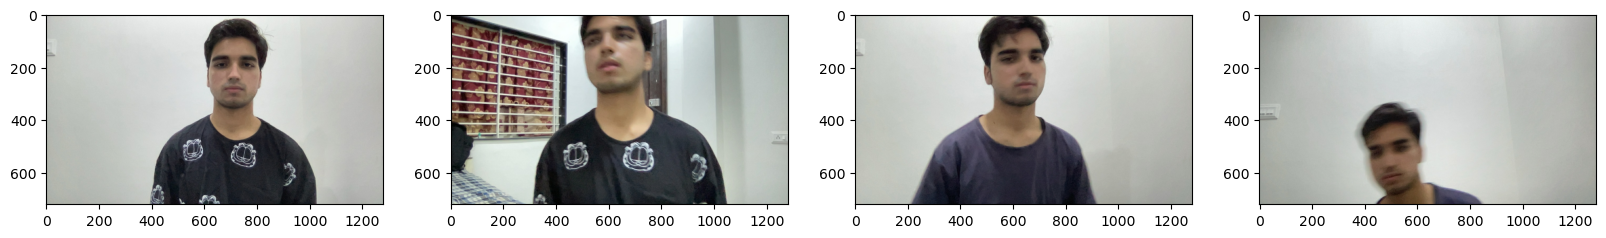

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):              
    ax[idx].imshow(image)
plt.show()

# Partition Unaugmented Data

## 3.1 MANUALLY SPLIT DATA INTO TRAIN TEST AND VAL

In [25]:
150*.7   # 105 to train

105.0

In [27]:
150*.15   #22 and 23 to val and test

22.5

## Move the Matching Labels

In [28]:
txt = "hello, my name is Peter, I am 26 years old"
txt.split(",")[0]

'hello'

In [29]:
for folder in ['train','test','val']:                               # script for matching the labels with data and move it
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on images and labels using ALBUMENTATION

## 4.1 Setup ALBUMENTATION Transform Pipeline

In [30]:
import albumentations as alb

In [31]:
img = cv2.imread(os.path.join('data','train','images','40a6e4ee-261c-11ed-acac-1abd0247c66a.jpg'))

In [32]:
img.shape        # getting an idea of img shape

(720, 1280, 3)

In [33]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels']))

## 4.2 Load a test image and annotation with OpenCV and JSON

In [67]:
img = cv2.imread(os.path.join('data','train','images','410223d6-261c-11ed-acac-1abd0247c66a.jpg'))

In [68]:
with open(os.path.join('data','train','labels','410223d6-261c-11ed-acac-1abd0247c66a.json'), 'r') as f:
    label = json.load(f)

In [69]:
type(label)

dict

In [70]:
type(label['shapes'])

list

In [71]:
label['shapes'][0]['points']                           #type(label) is dict.

[[554.7906976744187, 253.90697674418607], [792.0, 529.4883720930233]]

In [72]:
coords = [0,0,0,0]                                      
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [73]:
coords

[554.7906976744187, 253.90697674418607, 792.0, 529.4883720930233]

In [74]:
coords = list(np.divide(coords,[1280,720,1280,720]))            #normalizing the image

In [75]:
coords

[0.43343023255813956, 0.3526485788113695, 0.61875, 0.7354005167958656]

## 4.4 Apply Augmentations and view Results

In [76]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [77]:
augmented['image'].shape

(450, 450, 3)

In [78]:
augmented['class_labels']

['face']

In [79]:
augmented['bboxes']

[(0.8084237726098192, 0.4264599483204134, 1.0, 1.0)]

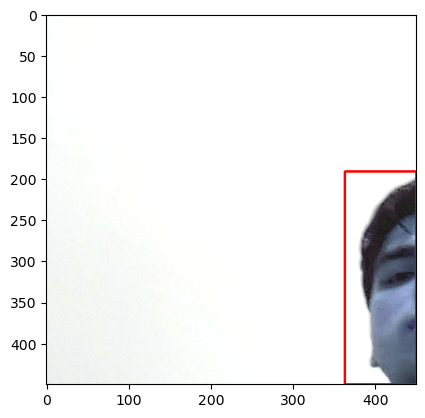

In [81]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0), 2)

plt.imshow(augmented['image'])

# 5 Build and Run Auhmentation Pipeline

## 5.1 Run Augmentation Pipeline

In [82]:
for partition in ['train','test','val']:                                         # doing it for the whole data and setting up aug data
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.559702034883721, 0.6530361757105942, 0.215625, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.9139898255813954, 0.570671834625323, 0.6109375, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.6741642441860465, 0.4689276485788114, 0.40234375, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.6205668604651163, 0.48992248062015503, 0.3796875, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.703234011627907, 0.45923772609819125, 0.4703125, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.5751453488372092, 0.507687338501292, 0.3453125, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.5896802325581396, 0.5060723514211887, 0.3421875, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.3107921511627907, 0.5512919896640827, 0.0, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.6832485465116279, 0.58843669250646, 0.28203125, 0.0, 'face'].
x

## 5.2 Load Augmented Images to Tensorflow Dataset

In [83]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)          # getting everyimage ending with .jpg
train_images = train_images.map(load_image)                                                # Loading the image
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))                   # compressing image further to feed into NN
train_images = train_images.map(lambda x: x/255)                                           # scaling it so we can use sigmoid function (0-1)

In [84]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [85]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# 6.Prepare Labels

## 6.1 Build Label Loading Function

In [86]:
def load_labels(label_path):                                          # return class and box coordinates
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## 6.2 Load labels to tensorflow Dataset

In [87]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [88]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [89]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [90]:
test_labels.as_numpy_iterator().next()

(array([1], dtype=uint8), array([0.917, 0.   , 1.   , 0.739], dtype=float16))

# Combine Label and image Samples

## 7.1 Check Partition Lengths

In [91]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1200, 1200, 1260, 1260)

## 7.2 Creaate Final Datasets (images/labels)

In [92]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [93]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

In [94]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8)
val = val.prefetch(4)

In [95]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [96]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1637, 0.    , 0.802 , 0.267 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.606 , 0.    , 1.    , 0.756 ]], dtype=float16))

## 7.3 Veiw Images and Annotation

In [146]:
data_sample = train.as_numpy_iterator()

In [159]:
res = data_sample.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


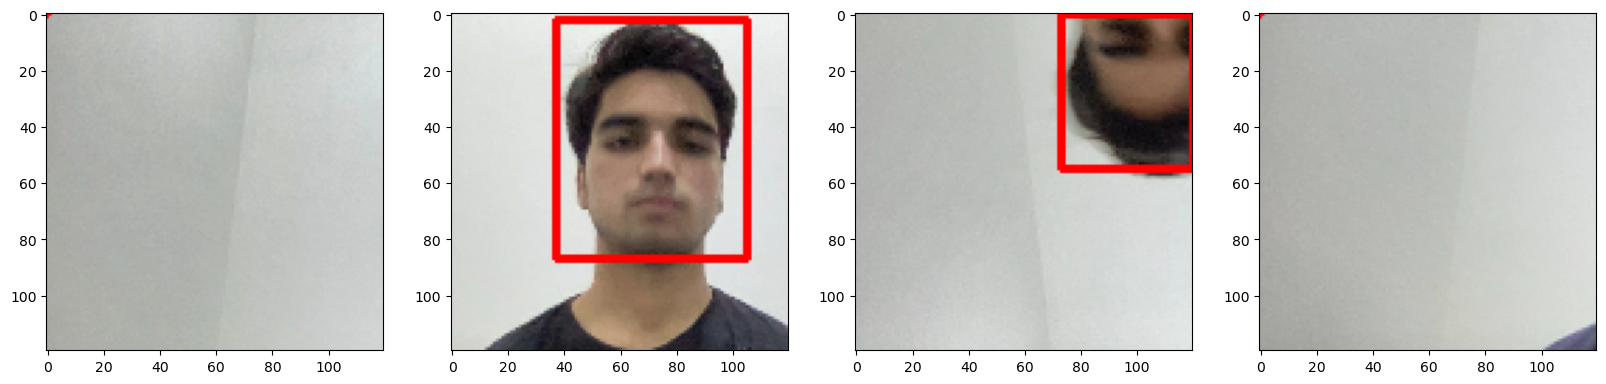

In [160]:
fix, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0),2 )
    ax[idx].imshow(sample_image)

# 8 Build Deep Learning Model using functional API

## 8.1 Import Layers and Base Network

In [161]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [162]:
vgg = VGG16(include_top = False)

In [163]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build Instance Of Network

In [164]:
def build_model():                                   # pro-tip : focus on input and outpu then tweak the hidden layers
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [165]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1752 , 0.08307, 0.8936 , 0.9253 ],
        [0.     , 0.4673 , 0.5137 , 1.     ],
        [0.2524 , 0.     , 0.994  , 0.6045 ],
        [0.819  , 0.     , 1.     , 0.7383 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

## 8.4 Test out Neural Network

In [166]:
facetracker = build_model()                                       

In [167]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [168]:
X, y = train.as_numpy_iterator().next()

In [169]:
X.shape

(8, 120, 120, 3)

In [170]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 215ms/step


2022-09-15 00:42:28.139431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [171]:
classes, coords

(array([[0.60928386],
        [0.62214017],
        [0.7012552 ],
        [0.5469763 ],
        [0.5169753 ],
        [0.6367476 ],
        [0.8363538 ],
        [0.82338595]], dtype=float32),
 array([[0.4684158 , 0.49000648, 0.37875715, 0.6781226 ],
        [0.5607919 , 0.32803077, 0.35394368, 0.73911047],
        [0.5144936 , 0.41653615, 0.41826102, 0.8046082 ],
        [0.5942073 , 0.33128092, 0.4433368 , 0.74316496],
        [0.57481617, 0.5321264 , 0.3924857 , 0.6224083 ],
        [0.56857336, 0.44018766, 0.34932908, 0.6539461 ],
        [0.56357694, 0.48911923, 0.45618936, 0.6629455 ],
        [0.5237248 , 0.5281359 , 0.48396194, 0.8015732 ]], dtype=float32))

# 9. Define Losses and Optimizers 

## 9.1 Define Optimizer and LR

In [172]:
len(train)

630

In [173]:
batches_per_epoch = len(train)                         # how much learning rate gonna drop each time we do 1 epoch
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [174]:
print(lr_decay)

0.000529100529100529


In [175]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [176]:
def localization_loss(y_true, yhat):      
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))       # dist. between our coord and predicted coord                   
    
    h_true = y_true[:,3] - y_true[:,1]                # find the actual formula of localization loss (this one is tweaked)
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))  # diff between ture width and pred.
                                                                                         # diff between true height and pred.
    
    return delta_coord + delta_size

In [177]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [178]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.038291>

In [179]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5675391>

In [180]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.038291>

# 10 Train Neural Network

## 10.1 Create Custom Model Class

In [181]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker
        
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)                      # X is our pre-processed data
            
            batch_classloss = self.closs(y[0], classes)                   # calculating classification loss
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)    # calculating regression loss (box)
            
            total_loss = batch_localizationloss + 0.5*batch_classloss                #total loss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)          # calculating gradients
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables))                 # applying gradient decent
        
        return {"total_loss" : total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [182]:
model = FaceTracker(facetracker)

In [183]:
model.compile(opt ,classloss, regressloss)

## 10.2 Train

In [184]:
logdir ='log'

In [185]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)    # create tensorflow log directory which you can 
                                                                         # pick up and review later

In [186]:
hist = model.fit(train, epochs=40, validation_data =val, callbacks = [tensorboard_callback])

Epoch 1/40


2022-09-15 00:57:30.233266: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'binary_crossentropy/cond/output/_10'
2022-09-15 00:57:30.238532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


630/630 [==============================] - ETA: 0s - total_loss: 0.8441 - class_loss: 0.2423 - regress_loss: 0.7230

2022-09-15 00:59:32.026131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


630/630 [==============================] - 132s 197ms/step - total_loss: 0.8431 - class_loss: 0.2419 - regress_loss: 0.7222 - val_total_loss: 0.0320 - val_class_loss: 0.0165 - val_regress_loss: 0.0237
Epoch 2/40
630/630 [==============================] - 131s 198ms/step - total_loss: 0.4183 - class_loss: 0.1337 - regress_loss: 0.3515 - val_total_loss: 0.0318 - val_class_loss: 0.0112 - val_regress_loss: 0.0261
Epoch 3/40
630/630 [==============================] - 137s 207ms/step - total_loss: 0.3011 - class_loss: 0.0987 - regress_loss: 0.2518 - val_total_loss: 0.0532 - val_class_loss: 0.0526 - val_regress_loss: 0.0269
Epoch 4/40
630/630 [==============================] - 139s 209ms/step - total_loss: 0.2194 - class_loss: 0.0726 - regress_loss: 0.1831 - val_total_loss: 0.7109 - val_class_loss: 0.5995 - val_regress_loss: 0.4111
Epoch 5/40
630/630 [==============================] - 141s 212ms/step - total_loss: 0.1737 - class_loss: 0.0609 - regress_loss: 0.1432 - val_total_loss: 0.0309 - v

## 10.3 Plot Performance

In [187]:
hist.history

{'total_loss': [0.2331874668598175,
  0.4865770936012268,
  0.2650408148765564,
  0.12601134181022644,
  0.056009478867053986,
  0.030963245779275894,
  0.10412497073411942,
  0.007170839700847864,
  0.6976442337036133,
  0.0006617034086957574,
  0.004057596437633038,
  0.022555435076355934,
  0.010339180007576942,
  0.03009571135044098,
  0.00987797137349844,
  0.0099716205149889,
  0.010402897372841835,
  0.0021379641257226467,
  0.01975966803729534,
  0.007228355389088392,
  0.0020533795468509197,
  0.005776639096438885,
  0.007303695194423199,
  0.0048409877344965935,
  0.675108015537262,
  1.5975898504257202,
  0.003584503661841154,
  0.00605920422822237,
  0.0011213230900466442,
  0.0014523356221616268,
  0.006909210700541735,
  0.001551403314806521,
  0.0042717638425529,
  0.0036646982189267874,
  0.0013232872588559985,
  0.0006690924637950957,
  0.0006517692818306386,
  0.003072288352996111,
  0.004103274084627628,
  0.00012234121095389128],
 'class_loss': [0.02928679622709751,

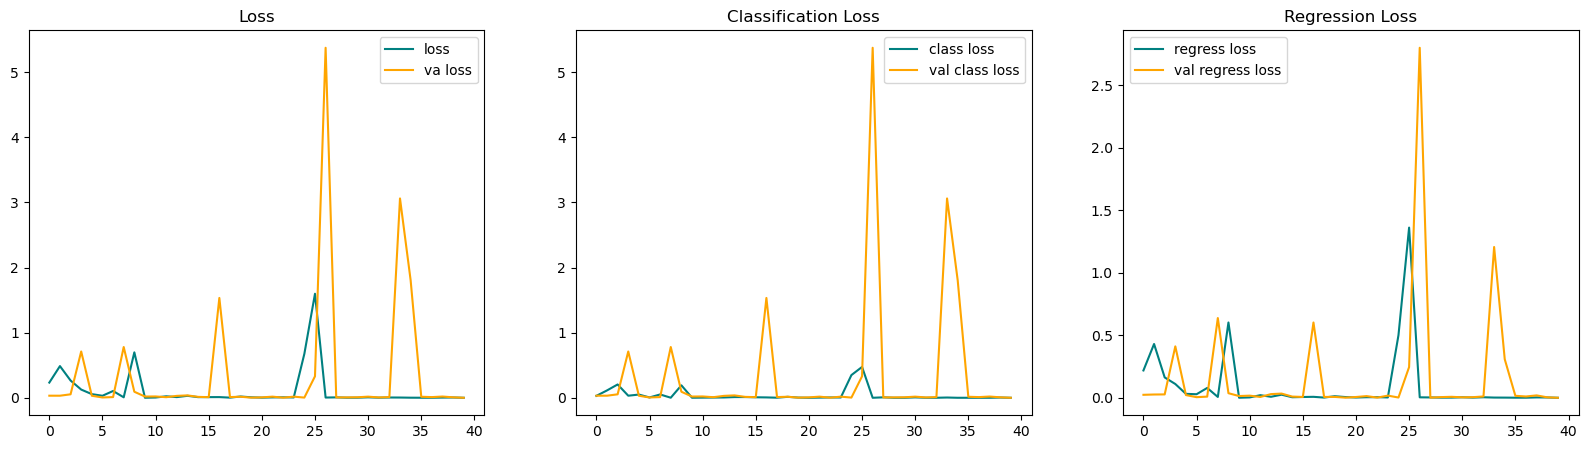

In [188]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='va loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_total_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()


ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

## 11.1 Make Predictions on Test Set

In [251]:
test_data = test.as_numpy_iterator()

In [273]:
test_sample = test_data.next()

In [274]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


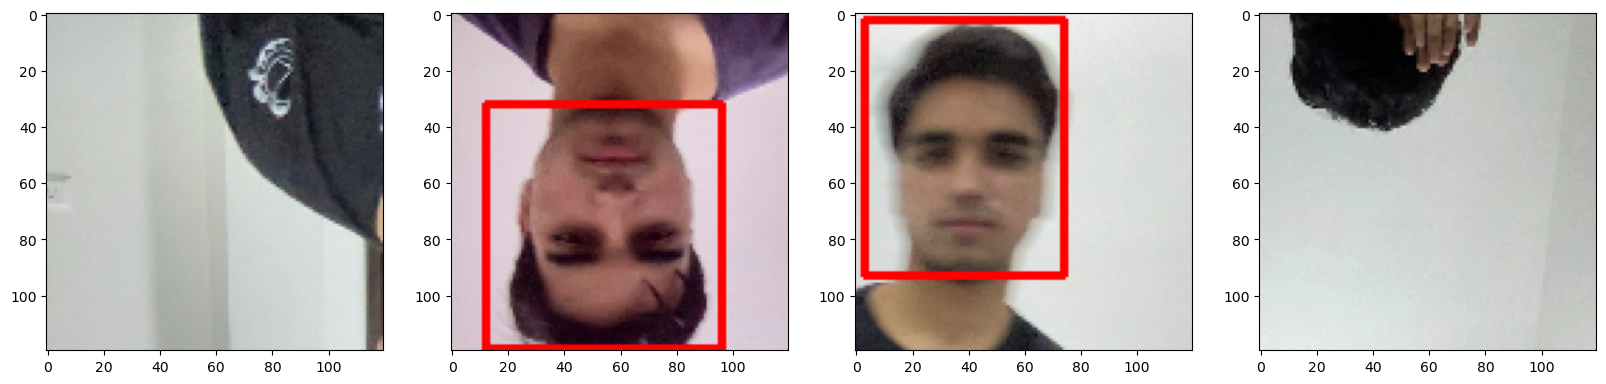

In [275]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                     tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                     tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0), 2)
        
    ax[idx].imshow(sample_image)

## 11.2 Save the Model

In [276]:
from tensorflow.keras.models import load_model

In [277]:
facetracker.save('facetracker.h5')

In [278]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [279]:
cap = cv2.VideoCapture(0)                  # giving the camera no.
while cap.isOpened():                   
    _ , frame = cap.read()
    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)           # converting image from bgr to rgb
    resized = tf.image.resize(rgb, (120,120))              # resizing the image
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5:
        #controls the main rectangle
        cv2.rectangle(frame,
                     tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                     tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      (255,0,0), 2)
        
        # controls the label rectangle
        cv2.rectangle(frame,
                     tuple(np.multiply(sample_coords[:2], [450,450]).astype(int),[0,-30]),
                     tuple(np.multiply(sample_coords[:2], [450,450]).astype(int),[80,0]),
                      (255,0,0), -1)
        
        # controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                                [0,-5])),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, CV2.LINE__AA)
        
    cv2.imshow('EyeTrack', frame)
    
    if cv2 .waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 185ms/step


2022-09-15 03:29:05.195608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


TypeError: tuple expected at most 1 argument, got 2